# *Bike Sharing Demand - Kaggle Competition*

# Forecast use of a city bikeshare system

In [1]:
% matplotlib inline

# importing libraries
import re
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# sci-kit learn libraries
from sklearn.cross_validation import train_test_split
from sklearn import linear_model as lm
from sklearn import preprocessing as pp
from sklearn import svm
from sklearn.ensemble import ExtraTreesClassifier as etc
from sklearn import cross_validation as cv
from sklearn import ensemble as ensmbl

# set seed
np.random.seed(0)

# Data Import

##Data Fields
```
01. datetime    - hourly date + timestamp  
02. season      -  1 = spring, 2 = summer, 3 = fall, 4 = winter 
03. holiday     - whether the day is considered a holiday
04. workingday  - whether the day is neither a weekend nor holiday
05. weather     - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
                  2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
                  3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
                  4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
06. temp        - temperature in Celsius
07. atemp       - "feels like" temperature in Celsius
08. humidity    - relative humidity
09. windspeed   - wind speed
10. casual      - number of non-registered user rentals initiated
11. registered  - number of registered user rentals initiated
12. count       - number of total rentals
```

In [2]:
# import training data set
df = pd.read_csv("../data/train.csv")
FINAL_TEST_DF = pd.read_csv("../data/test.csv")
train_df = df.copy(deep=True)

In [3]:
# preview data
train_df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0,0,1,1


# Data Cleansing / Pre-Processing

Let's see how data looks like

In [263]:
train_df['year'].unique()

array([2011, 2012], dtype=int64)

In [264]:
train_df['weather'].unique()

array([1, 2, 3, 4], dtype=int64)

In [429]:
train_df['month'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12], dtype=int64)

In [22]:
train_df['workingday'].unique()

array([0, 1], dtype=int64)

In [23]:
train_df['holiday'].unique()

array([0, 1], dtype=int64)

In [24]:
train_df['season'].unique()

array([1, 2, 3, 4], dtype=int64)

**Create index based on `datetime` and parse `datetime` field to extract year, month, day, hour and day of the week.**

In [3]:
def processDateTime(df):  
    #Create new columns for day, month, year, hour
    df.index = pd.to_datetime(df['datetime']) # creating an index from the timestamp
    df['year'] = pd.DatetimeIndex(df['datetime']).year # year
    df['month'] = pd.DatetimeIndex(df['datetime']).month # month
    df['day'] = pd.DatetimeIndex(df['datetime']).day # day
    df['hours'] = pd.DatetimeIndex(df['datetime']).hour # hour
    df['dayofweek'] = pd.DatetimeIndex(df['datetime']).dayofweek # day of the week 0 = Monday to 6 = Sunday
    df['rownum'] = range(1,len(df)+1) 
    
    return df

In [8]:
train_df = processDateTime(train_df)
FINAL_TEST_DF = processDateTime(FINAL_TEST_DF)
train_df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hours,dayofweek,rownum
datetime,,,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0,3,13,16,2011,1,1,0,5,1
2011-01-01 01:00:00,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0,8,32,40,2011,1,1,1,5,2
2011-01-01 02:00:00,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0,5,27,32,2011,1,1,2,5,3
2011-01-01 03:00:00,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0,3,10,13,2011,1,1,3,5,4
2011-01-01 04:00:00,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0,0,1,1,2011,1,1,4,5,5


** Calculating median total count for every hour and week of the day**

Choosing median to reduce the effect of outliers

In [5]:
def calcMedianByDay(df):
    df['mediancountbyday'] = np.zeros(len(df))
    for d in xrange(7):
        for h in xrange(24):
            df.loc[(df.dayofweek == d) & (df.hours == h), 'mediancountbyday'] = np.median(train_df['count'][(train_df.dayofweek == d) & (train_df.hours == h)])

    return df

In [10]:
train_df = calcMedianByDay(train_df)
FINAL_TEST_DF = calcMedianByDay(FINAL_TEST_DF)

In [11]:
train_df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hours,dayofweek,rownum,mediancountbyday
datetime,,,,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0,3,13,16,2011,1,1,0,5,1,95.0
2011-01-01 01:00:00,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0,8,32,40,2011,1,1,1,5,2,70.5
2011-01-01 02:00:00,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0,5,27,32,2011,1,1,2,5,3,51.0
2011-01-01 03:00:00,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0,3,10,13,2011,1,1,3,5,4,23.0
2011-01-01 04:00:00,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0,0,1,1,2011,1,1,4,5,5,7.0


**Preview transformations**

In [32]:
print 'total rows in training data set: %d' % (len(train_df))
train_df.head(10)

total rows in training data set: 10886


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hours,dayofweek,rownum,mediancountbyday
datetime,,,,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16,2011,1,1,0,5,1,95.0
2011-01-01 01:00:00,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40,2011,1,1,1,5,2,70.5
2011-01-01 02:00:00,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32,2011,1,1,2,5,3,51.0
2011-01-01 03:00:00,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13,2011,1,1,3,5,4,23.0
2011-01-01 04:00:00,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1,2011,1,1,4,5,5,7.0
2011-01-01 05:00:00,2011-01-01 05:00:00,1,0,0,2,9.84,12.880,75,6.0032,0,1,1,2011,1,1,5,5,6,8.0
2011-01-01 06:00:00,2011-01-01 06:00:00,1,0,0,1,9.02,13.635,80,0.0000,2,0,2,2011,1,1,6,5,7,20.5
2011-01-01 07:00:00,2011-01-01 07:00:00,1,0,0,1,8.20,12.880,86,0.0000,1,2,3,2011,1,1,7,5,8,46.5
2011-01-01 08:00:00,2011-01-01 08:00:00,1,0,0,1,9.84,14.395,75,0.0000,1,7,8,2011,1,1,8,5,9,118.5


# Exploratory Analysis
## i. Total bike rentals (count) distribution

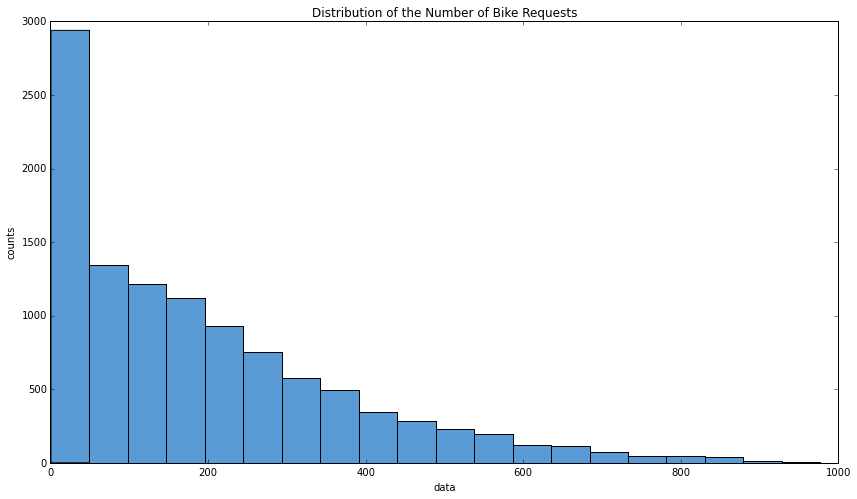

In [62]:
fig = plt.figure(figsize=(12,7))
ax = fig.add_subplot(111)
plt.hist(train_df['count'], bins =20, color='#5b9bd5')
ax.set_xlabel('data')
ax.set_ylabel('counts')
ax.set_title("Distribution of the Number of Bike Requests")
plt.tight_layout()
plt.savefig("../images/dist-bike-requests-count.jpg", dpi=150)
plt.show()

## ii. Correlation

In [65]:
# correlation matrix between all variables
train_df = train_df.drop(['datetime'], 1)
correlation = train_df.corr(method = 'pearson', min_periods = 1)
correlation.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hours,dayofweek,rownum,mediancountbyday
count,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000
mean,0.191453,0.033760,-0.002421,0.048677,0.227337,0.224510,-0.013068,0.048488,0.222018,0.275394,0.290859,0.141014,0.192373,0.062861,0.149208,0.002518,0.221140,0.208299
std,0.323004,0.252395,0.314193,0.263460,0.319912,0.321321,0.327223,0.266021,0.340235,0.357133,0.373036,0.303393,0.324284,0.234413,0.284795,0.307534,0.311292,0.358002
min,-0.147121,-0.250491,-0.704267,-0.135918,-0.064949,-0.057473,-0.348187,-0.318607,-0.348187,-0.265458,-0.317371,-0.078606,-0.150192,-0.015877,-0.278011,-0.704267,-0.086245,-0.307598
25%,-0.006013,-0.006654,-0.006967,-0.053200,0.004109,-0.000945,-0.274873,-0.049306,0.055918,0.037096,0.013652,-0.004762,-0.003112,0.000602,-0.004672,-0.039792,-0.004486,-0.005400
50%,0.063063,-0.000030,0.006305,-0.007482,0.149088,0.142504,-0.035021,0.007835,0.159288,0.216858,0.213633,-0.000341,0.052433,0.005902,0.001956,-0.010811,0.108744,0.006829
75%,0.241669,0.010109,0.021839,0.008474,0.303601,0.302163,0.024861,0.091970,0.465839,0.365048,0.399064,0.124237,0.244326,0.018221,0.263192,-0.003140,0.314271,0.405048
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


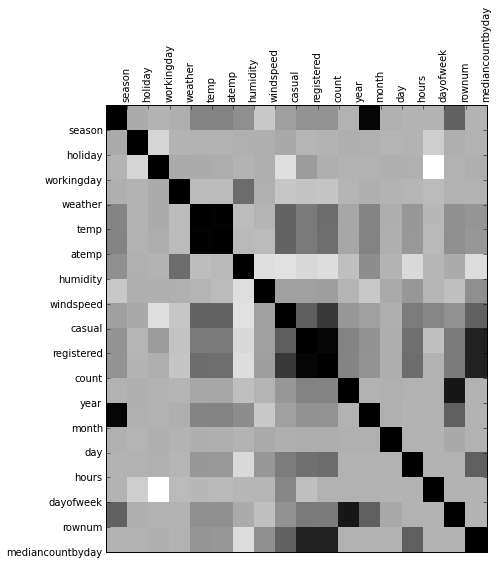

In [66]:
col_names = train_df.columns.values.tolist() 
row_names = train_df.columns.values.tolist()
data = correlation

fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(121)
heatmap = ax.pcolor(data, cmap=plt.cm.Greys)

# put the major ticks at the middle of each cell
ax.set_xticks(np.arange(data.shape[0])+1, minor=False)
ax.set_yticks(np.arange(data.shape[1])+1, minor=False)

# want a more natural, table-like display
ax.invert_yaxis()
ax.xaxis.tick_top()

ax.set_xticklabels(row_names, minor=False, rotation='vertical')
ax.set_yticklabels(col_names, minor=False, rotation='horizontal')
plt.savefig("../images/correlations.jpg", dpi=150)
plt.show()

Some findings from the correlation matrix

- Well correlated 
  - season and month
  - season and weather
  - season and temperature
  - season and humidity
  - working day and registered - (obvious) working days means commuters
  - atemp and weather
  - atemp and windspeed
  - atemp and registered
  - atemp and count
  - casual and holiday
  - casual and season
  - casual and windspeed
  - casual and year, hour, day and day of the week
  - casual and atemp
  - casual and median count
  - registered and season
  - registered and atemp
  - registered and windspeed
  - registered and year and hour
  - registered and median
  - count and season
  - count and weather
  - count and atemp
  - count and windspeed
  - count and year, hour
  - count and median

- Somewhat correlated
  - workingday and holiday
  - windspeed and day

How about checking p-value? (data exploration is fun!)

In [275]:
from scipy.stats import pearsonr
import itertools

n = len(train_df.columns)
r = [pearsonr(train_df[[i]], train_df[[j]]) + (train_df.columns.values[i], train_df.columns.values[j]) for i in np.arange(n) for j in np.arange(n)]
r = np.array(r)
r[:, 1] = np.hstack(r[:, 1])
r[:, 0] = np.hstack(r[:, 0])

corr_m = pd.DataFrame(r[:,:], columns=['PearsonR', 'pValue', 'corX', 'corY'])
corr_m['significance'] = corr_m.apply(lambda row: '***' if row[1] <= .001 else '**' if row[1] <= .01 else '*' if row[1] <= .01 else '-', axis=1)

corr_m.query(' PearsonR != 1 and significance != "-" and corX != "rownum" and corY != "rownum" and ( PearsonR >= 0.3 or PearsonR <= -0.3) ')

,PearsonR,pValue,corX,corY,significance
12,0.9715238,0,season,month,***
44,-0.319111,3.561967e-256,workingday,casual,***
51,-0.7042674,0,workingday,dayofweek,***
60,0.4062437,0,weather,humidity,***
77,0.9849481,0,temp,atemp,***
80,0.4670971,0,temp,casual,***
81,0.3185713,2.869679e-255,temp,registered,***
82,0.3944536,0,temp,count,***
94,0.9849481,0,atemp,temp,***
98,0.4620665,0,atemp,casual,***


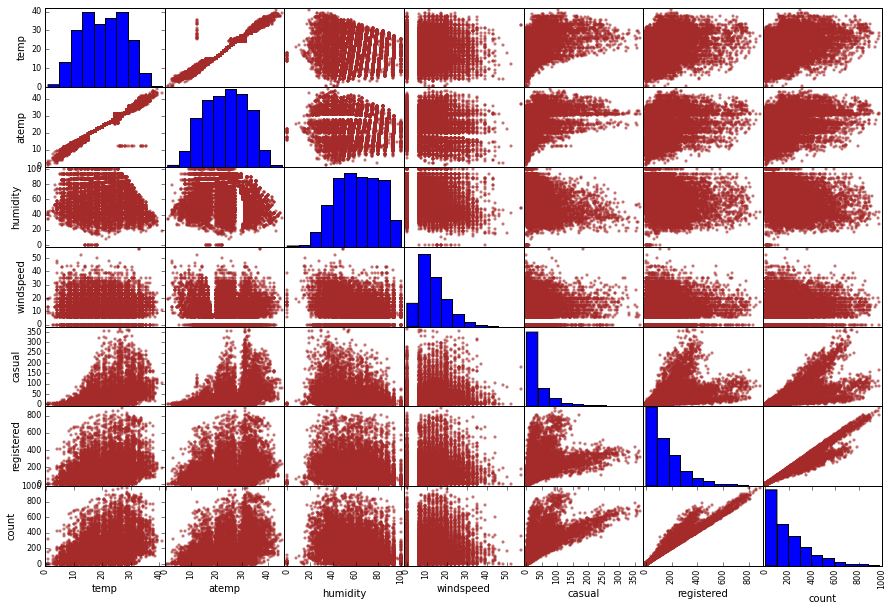

In [21]:
_ = pd.tools.plotting.scatter_matrix(train_df.ix[:,5:12], figsize=(15,10), diagonal='hist', color='brown')

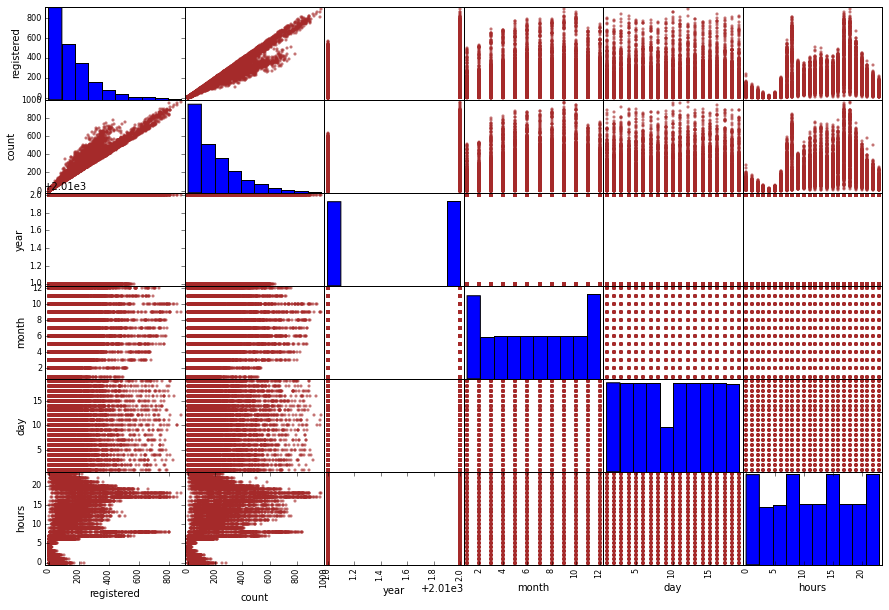

In [23]:
_ = pd.tools.plotting.scatter_matrix(train_df.ix[:,10:16], figsize=(15,10), diagonal='hist', color='brown')

#### Why casual and registered users should be modeled separately?

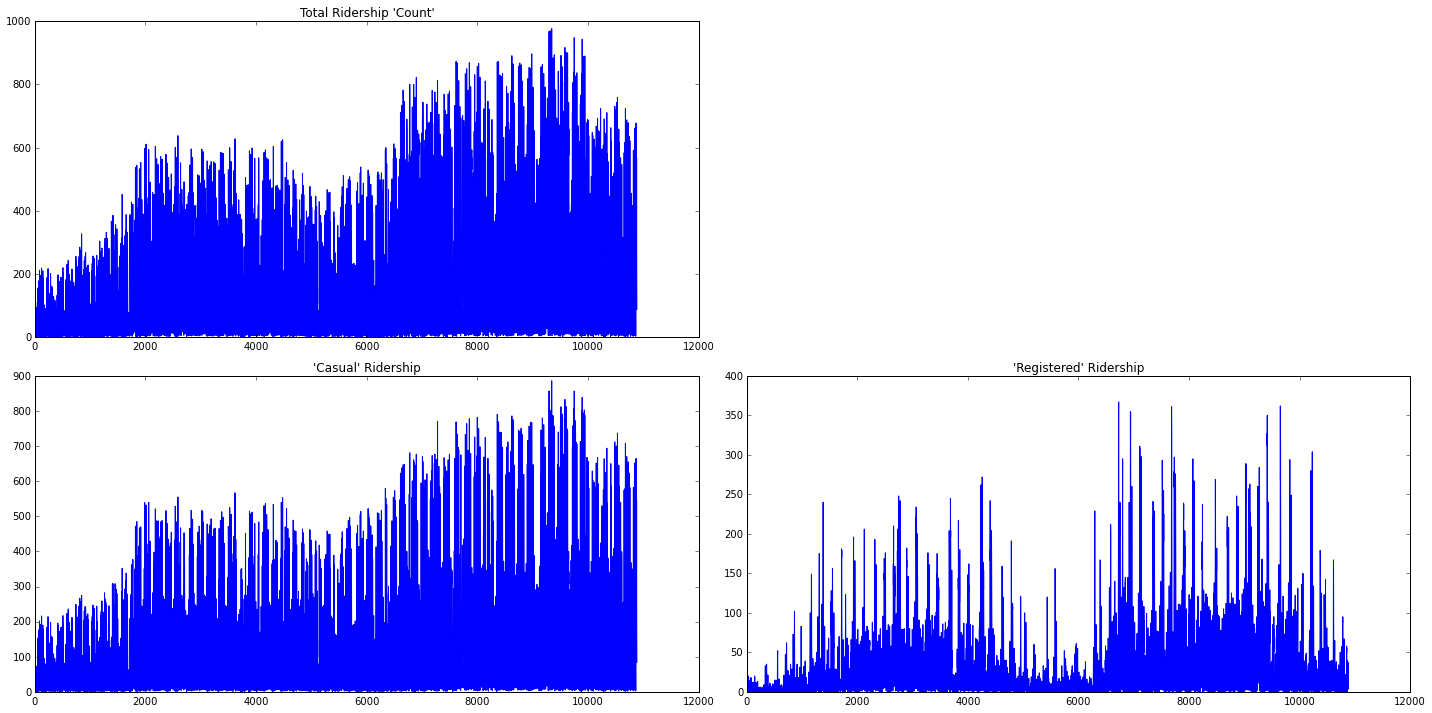

In [30]:
fig = plt.figure(figsize=(20,10))
ax1 = plt.subplot(221); ax1.set_title("Total Ridership 'Count'")
ax1.plot(train_df['count'])
ax2 = plt.subplot(223); ax2.set_title("'Casual' Ridership")
ax2.plot(train_df['registered'])
ax3 = plt.subplot(224); ax3.set_title("'Registered' Ridership")
ax3.plot(train_df['casual'])

plt.tight_layout()
plt.show()

## iii. Exploratory analysis

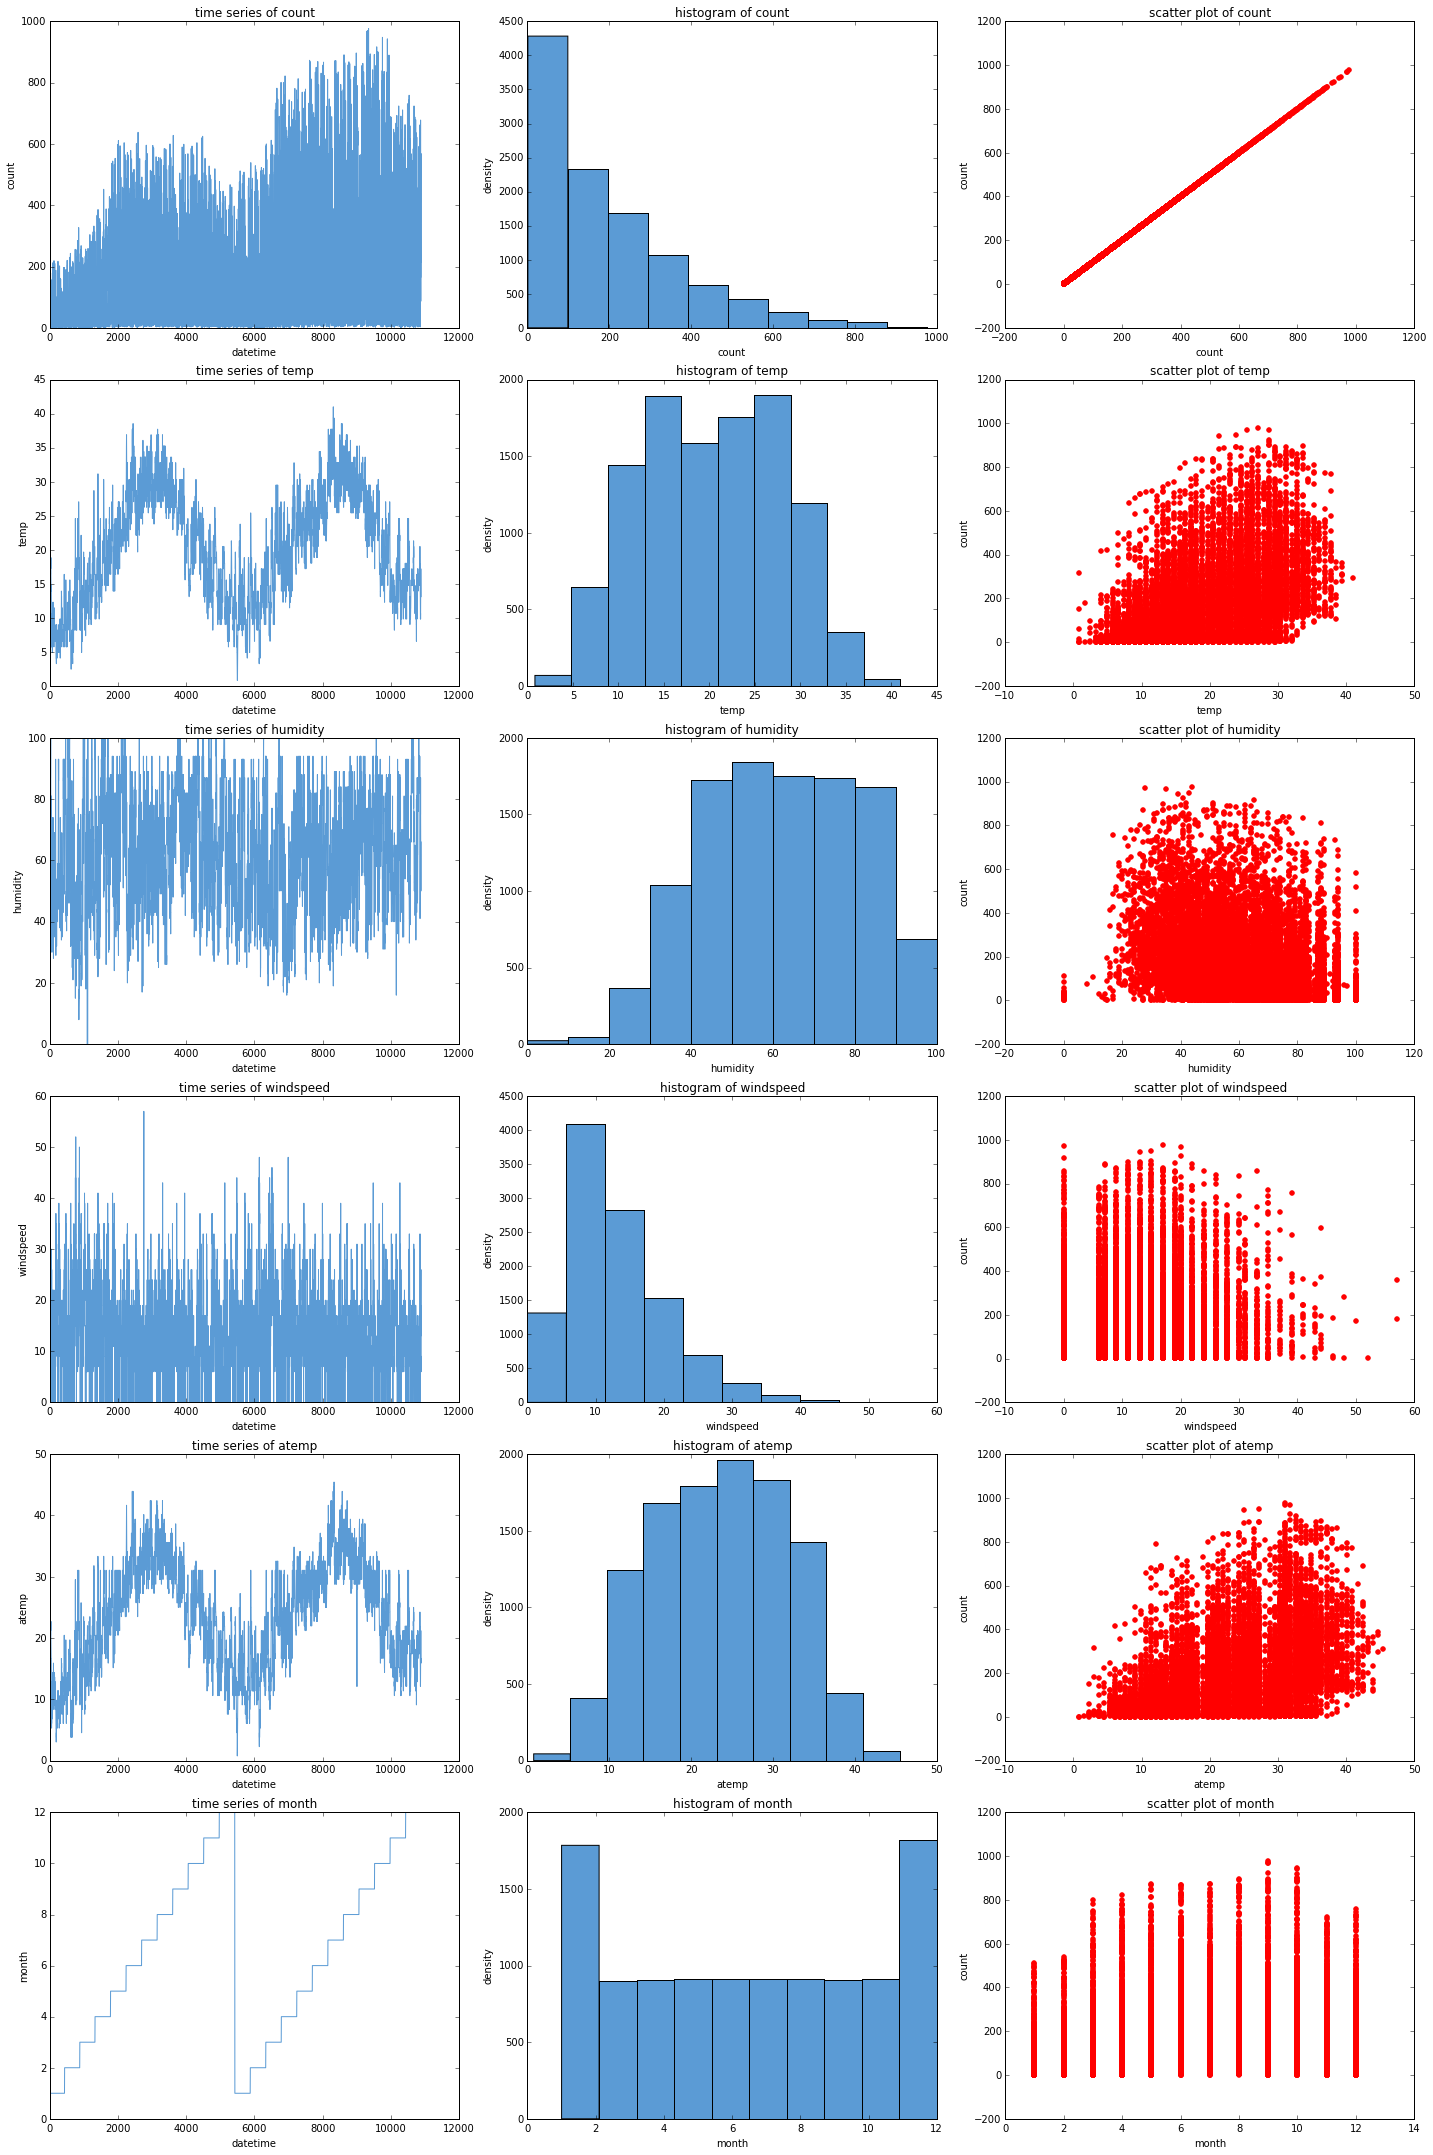

In [303]:
# data exploratory analysis
fig = plt.figure(figsize=(20,30))

subplots_adjust(hspace=0.000)
number_of_subplots=18

col_names = ['count', 'temp', 'humidity', 'windspeed', 'atemp', 'month']
no_of_axes = 3

for v in np.arange(0, number_of_subplots, 3):
    ax1 = subplot(number_of_subplots/3, 3, v+1)
    ax1.plot(train_df[col_names[v/3]], color='#5b9bd5')
    ax1.set_xlabel("datetime")
    ax1.set_ylabel(col_names[v/3])
    ax1.set_title('time series of ' + col_names[v/3])
    
    ax2 = subplot(number_of_subplots/3, 3, v+2)
    ax2.hist(train_df[col_names[v/3]], color='#5b9bd5')
    ax2.set_xlabel(col_names[v/3])
    ax2.set_ylabel("density")
    ax2.set_title('histogram of ' + col_names[v/3])

    ax3 = subplot(number_of_subplots/3, 3, v+3)
    ax3.scatter(train_df[col_names[v/3]], train_df['count'], color='red')
    ax3.set_xlabel(col_names[v/3])
    ax3.set_ylabel("count")
    ax3.set_title('scatter plot of ' + col_names[v/3])
    
plt.tight_layout()
plt.savefig("../images/data_exploration_1.jpg", dpi=150)
plt.show()

## iv. Total rentals, registered and casual users

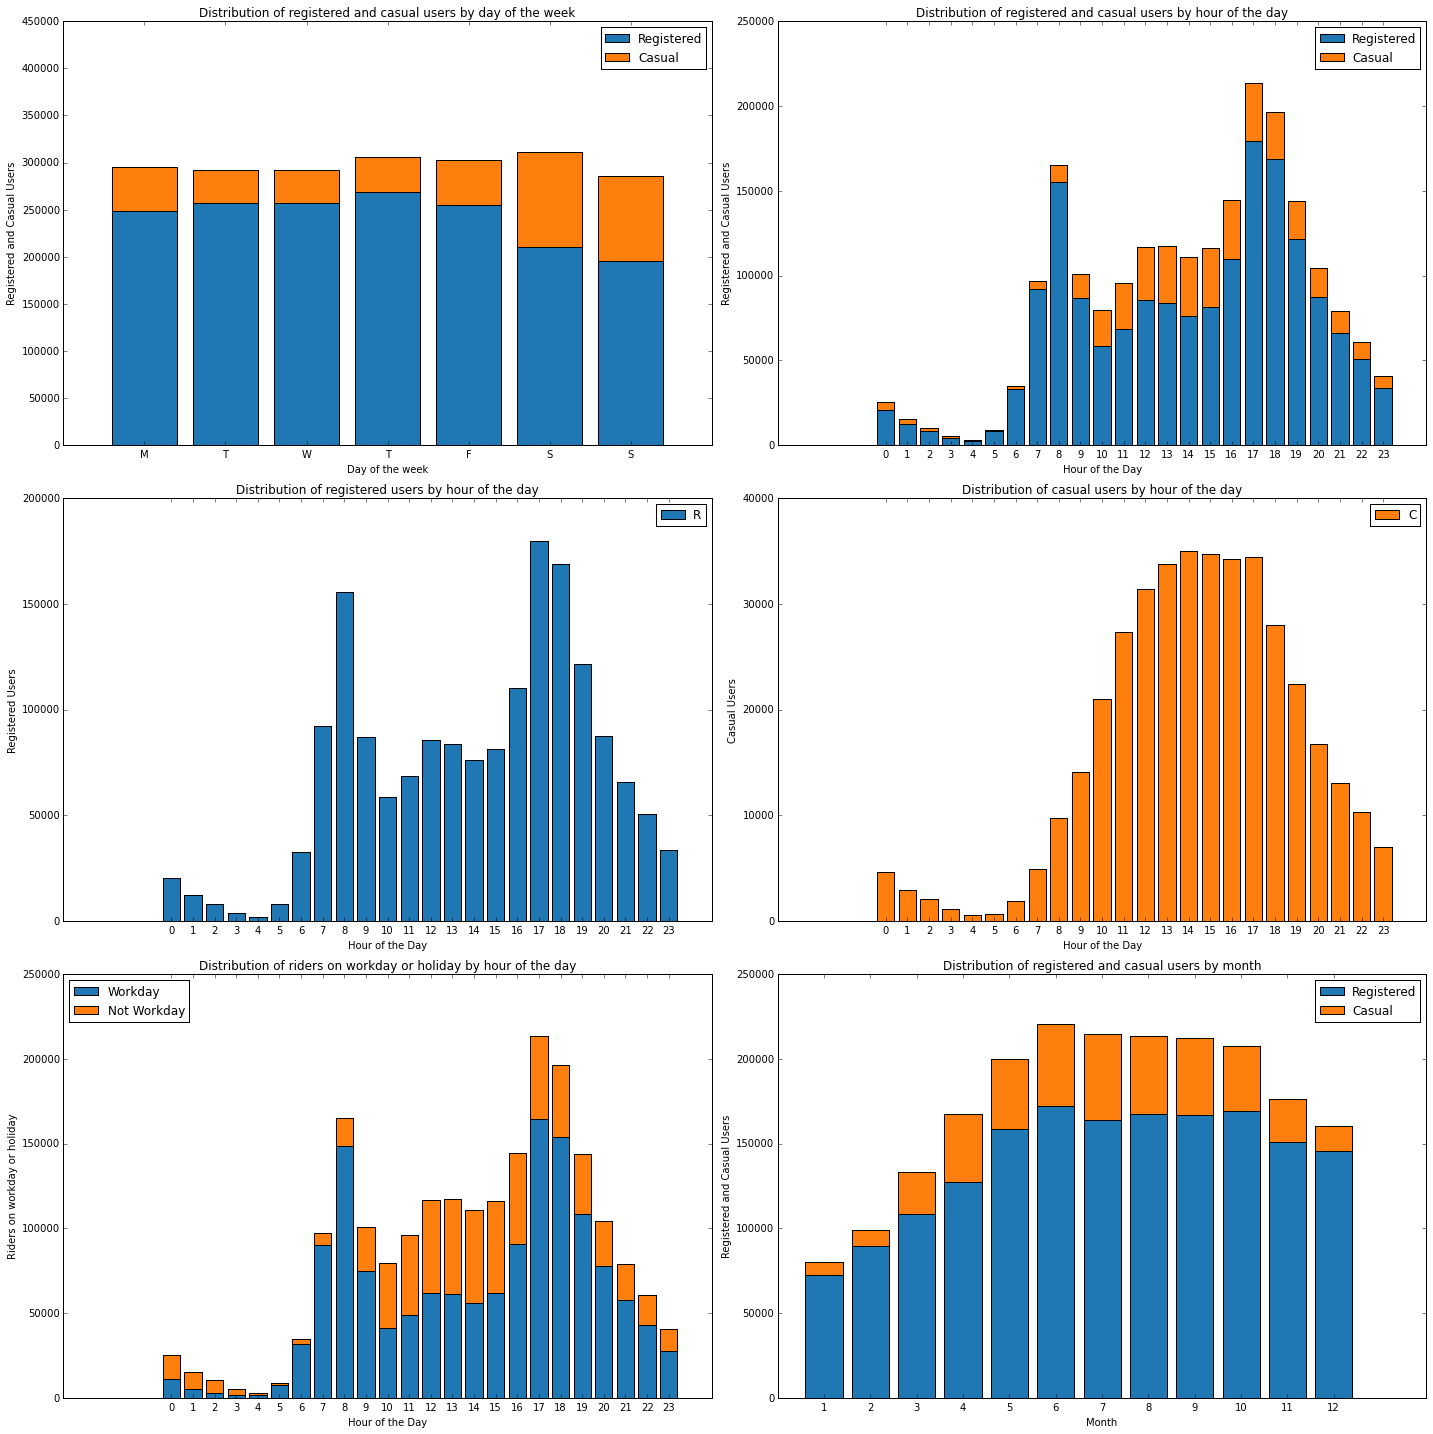

In [60]:
# analyze dependent variables
fig = plt.figure(figsize=(20, 20))

# Defining a color pattern based
colors = np.array([(31, 119, 180), (255, 127, 14)])/255.

plt.subplots_adjust(hspace = 0.000)

group = train_df['dayofweek']
ind = range(7)
x_ticks = ('M', 'T', 'W', 'T', 'F', 'S', 'S')

df_reg = np.bincount(group, weights=train_df['registered'])
df_cas = np.bincount(group, weights=train_df['casual'])

ax1 = plt.subplot(3, 2, 1)
ax1.bar(ind, df_reg, color=colors[0], align='center')
ax1.bar(ind, df_cas, color=colors[1], bottom = df_reg, align='center')
ax1.set_xlabel("Day of the week")
ax1.set_ylabel("Registered and Casual Users")
ax1.set_title('Distribution of registered and casual users by day of the week')
plt.legend(labels = ('Registered', 'Casual'), ncol=1, loc='upper right')
ax1.set_yticks(np.arange(0, 500000, 50000))
plt.xticks(ind, ('M', 'T', 'W', 'T', 'F', 'S', 'S'), horizontalalignment = 'center')

group = train_df['hours']
ind = range(24)
df_reg = np.bincount(group, weights=train_df['registered'])
df_cas = np.bincount(group, weights=train_df['casual'])

ax2 = plt.subplot(3, 2, 2)
ax2.bar(ind, df_reg, color=colors[0], align='center')
ax2.bar(ind, df_cas, color=colors[1], bottom = df_reg, align='center')
ax2.set_xlabel("Hour of the Day")
ax2.set_ylabel("Registered and Casual Users")
ax2.set_title('Distribution of registered and casual users by hour of the day')
plt.legend(labels = ('Registered', 'Casual'), ncol=1, loc='upper right')
ax2.set_yticks(np.arange(0, 300000, 50000))
plt.xticks(ind, horizontalalignment = 'center')

ax3 = plt.subplot(3, 2, 3)
ax3.bar(ind, df_reg, color=colors[0], align='center')
ax3.set_xlabel("Hour of the Day")
ax3.set_ylabel("Registered Users")
ax3.set_title('Distribution of registered users by hour of the day')
plt.legend(labels = ('Registered'), ncol=1, loc='upper right')
ax3.set_yticks(np.arange(0, 250000, 50000))
plt.xticks(ind, horizontalalignment = 'center')

ax4 = plt.subplot(3, 2, 4)
ax4.bar(ind, df_cas, color=colors[1], align='center')
ax4.set_xlabel("Hour of the Day")
ax4.set_ylabel("Casual Users")
ax4.set_title('Distribution of casual users by hour of the day')
plt.legend(labels = ('Casual'), ncol=1, loc='upper right')
ax4.set_yticks(np.arange(0, 50000, 10000))
plt.xticks(ind, horizontalalignment = 'center')

group_w = train_df.loc[train_df.workingday==1,'hours']
group_nw = train_df.loc[train_df.workingday==0,'hours']
ind = range(24)
df_workday = np.bincount(group_w, weights=train_df.loc[train_df.workingday==1, 'count'])
df_not_workday = np.bincount(group_nw, weights=train_df.loc[train_df.workingday==0, 'count'])

ax5 = plt.subplot(3, 2, 5)
ax5.bar(ind, df_workday, color=colors[0], align='center')
ax5.bar(ind, df_not_workday, color=colors[1], bottom = df_workday, align='center')
ax5.set_xlabel("Hour of the Day")
ax5.set_ylabel("Riders on workday or holiday")
ax5.set_title('Distribution of riders on workday or holiday by hour of the day')
plt.legend(labels = ('Workday', 'Not Workday'), ncol=1, loc='upper left')
ax5.set_yticks(np.arange(0, 300000, 50000))
plt.xticks(ind, horizontalalignment = 'center')

group = train_df['month']
ind = np.arange(1, 13, 1)
df_reg = np.bincount(group, weights=train_df['registered'])
df_cas = np.bincount(group, weights=train_df['casual'])

ax6 = plt.subplot(3, 2, 6)
ax6.bar(ind, df_reg[1:], color=colors[0], align='center')
ax6.bar(ind, df_cas[1:], color=colors[1], bottom = df_reg[1:], align='center')
ax6.set_xlabel("Month")
ax6.set_ylabel("Registered and Casual Users")
ax6.set_title('Distribution of registered and casual users by month')
plt.legend(labels = ('Registered', 'Casual'), ncol=1, loc='upper right')
ax6.set_yticks(np.arange(0, 300000, 50000))
plt.xticks(ind, horizontalalignment = 'center')

plt.tight_layout()
plt.savefig("../images/data_exploration_2.jpg", dpi=150)
plt.show()

Let's see those peak hours closely for each day

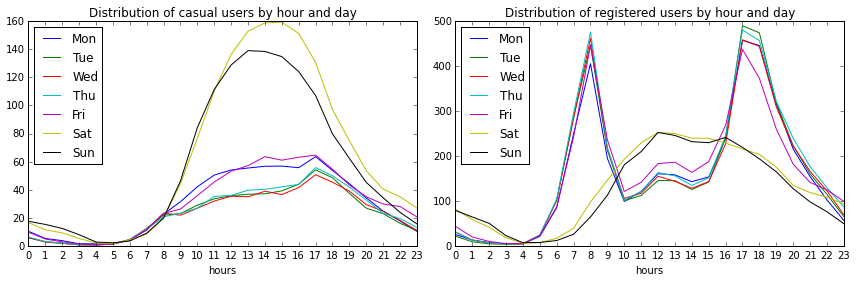

In [38]:
fig,axes = plt.subplots(figsize=(12, 4), nrows=1, ncols=2)
dy_cas = train_df.groupby(['dayofweek','hours'])['casual'].mean()
dy_reg = train_df.groupby(['dayofweek','hours'])['registered'].mean()

plt.sca(axes[0])
dy = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']

for i in range(7):
    dy_cas[i].plot(kind = 'line',label = dy[i])

axes[0].set_title('Distribution of casual users by hour and day')
plt.xticks(list(range(24)), horizontalalignment = 'center')
plt.legend(loc='upper left')

plt.sca(axes[1])
for i in range(7):
    dy_reg[i].plot(kind = 'line',label = dy[i])

axes[1].set_title('Distribution of registered users by hour and day')
plt.xticks(list(range(24)), horizontalalignment = 'center')
plt.legend(loc='upper left')

plt.tight_layout()
plt.savefig("../images/casual_registered.jpg", dpi=150)
plt.show()

In [434]:
group = train_df['month']
print np.bincount(group, weights=train_df['registered'])

[      0.   72632.   89816.  108445.  127589.  158862.  172159.  163670.
  167646.  166628.  169347.  151087.  145460.]


# Modeling

###Split Training Data into Test, Dev and Mini training

In [30]:
feature_names = ['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp', 'humidity', 'windspeed', 'year', 'month', 'day', 'hours', 'dayofweek', 'mediancountbyday']
label_names = ['casual', 'registered', 'count']

X = train_df[feature_names].values
print "Shape of all features: ", X.shape
Y = train_df[label_names].values
print "Shape of labels: ", Y.shape

final_test_data = FINAL_TEST_DF[feature_names].values
print "Shape of KAGGLE TEST SET: ", final_test_data.shape

Shape of all features:  (10886L, 14L)
Shape of labels:  (10886L, 3L)
Shape of KAGGLE TEST SET:  (6493L, 14L)


In [33]:
# create train and test sets for registered, casual, and total count predictions
train_r, test_r, train_r_labels, test_r_labels = train_test_split(X, Y[:, 1], train_size = 0.8)
train_c, test_c, train_c_labels, test_c_labels = train_test_split(X, Y[:, 0], train_size = 0.8)
train, test, train_labels, test_labels = train_test_split(X, Y[:, 2], train_size = 0.8)

train_r, dev_r, train_r_labels, dev_r_labels = train_test_split(train_r, train_r_labels, train_size = 0.75)
train_c, dev_c, train_c_labels, dev_c_labels = train_test_split(train_c, train_c_labels, train_size = 0.75)
train, dev, train_labels, dev_labels = train_test_split(train, train_labels, train_size = 0.75)

print '----------------'
print 'registered users'
print '----------------'
print 'train r data shape: ', train_r.shape
print 'train r label shape:', train_r_labels.shape
print 'dev r data shape: ', dev_r.shape
print 'dev r label shape:', dev_r_labels.shape
print 'test r data shape: ', test_r.shape
print 'test r labels shape:', test_r_labels.shape

print '----------------'
print 'casual users'
print '----------------'
print 'train c data shape: ', train_c.shape
print 'train c label shape:', train_c_labels.shape
print 'dev c data shape: ', dev_c.shape
print 'dev c label shape:', dev_c_labels.shape
print 'test c data shape: ', test_c.shape
print 'test c labels shape:', test_c_labels.shape

print '----------------'
print 'all users'
print '----------------'
print 'train data shape: ', train.shape
print 'train label shape:', train_labels.shape
print 'dev data shape: ', dev.shape
print 'dev label shape:', dev_labels.shape
print 'test data shape: ', test.shape
print 'test labels shape:', test_labels.shape

----------------
registered users
----------------
train r data shape:  (6531L, 14L)
train r label shape: (6531L,)
dev r data shape:  (2177L, 14L)
dev r label shape: (2177L,)
test r data shape:  (2178L, 14L)
test r labels shape: (2178L,)
----------------
casual users
----------------
train c data shape:  (6531L, 14L)
train c label shape: (6531L,)
dev c data shape:  (2177L, 14L)
dev c label shape: (2177L,)
test c data shape:  (2178L, 14L)
test c labels shape: (2178L,)
----------------
all users
----------------
train data shape:  (6531L, 14L)
train label shape: (6531L,)
dev data shape:  (2177L, 14L)
dev label shape: (2177L,)
test data shape:  (2178L, 14L)
test labels shape: (2178L,)


# Kaggle Submission Related

##RMSLE Score Function (for Kaggle Evaluation)

In [76]:
def RMSLE_score(Y_pred, Y_act ):
    a = (np.log(Y_pred+1)-np.log(Y_act+1))
    b = 1./len(Y_pred)
    score = (b*sum(a**(2)))**(0.5)
    return score

In [77]:
def RMSE_score(log_Y_pred, log_Y_act):
    n = len(log_Y_pred)
    return np.sqrt(1/n*(np.sum((log_Y_pred-log_Y_act)**2)))

In [78]:
def make_kaggle_submission(predictions, file_name):
    print "-" * 80

    # check shape of the test and prediction sets
    print "Generating file for Kaggle Submission File: %s" % (file_name)
    print "Shape of Kaggle Test Data: ", FINAL_TEST_DF.shape
    print "Shape of Kaggle Test Predictions: ", predictions.shape  

    # formatting predictions to integers and removing negative values
    predictions = np.rint(predictions)
    predictions[ predictions < 0] = 0
    print predictions
    
    print "Shape of Final Predictions: ", predictions.shape

    # create submission file
    #sbmt_file_name = [os.getcwd(),'../submissions/',file_name]
    sbmt_file_name = file_name
    np.savetxt(sbmt_file_name, zip(FINAL_TEST_DF['datetime'], predictions), delimiter=',', fmt="%s", header=','.join(['datetime','count']), comments='')
    print "kaggle submission file generated"

In [79]:
def print_model_summary(estimator, features, labels):
    # coefficients and intercept
    if 'coef_' in dir(estimator):
        print "Coefficients: \n%s\n" % estimator.coef_
    
    if 'intercept_' in dir(estimator):
        print "Intercept: \n%s\n" % estimator.intercept_
    
    predictions = estimator.predict(features)
    actuals = labels
    
    # mean square error
    print "Residual sum of squares R^2: %.2f" % np.mean((predictions - actuals) ** 2)
    # explained variance score: 1 is perfect prediction
    print "Variance score: %.2f" % estimator.score(features, labels)
    # root mean square log error
    predictions[predictions < 0] = 0
    print "RMSLE score: %.6f" % RMSLE_score(predictions, actuals)

## Baseline Submission with Linear Regression

In [46]:
# LinearRegression classifiers
lr   = lm.LinearRegression()
lr_c = lm.LinearRegression()
lr_r = lm.LinearRegression()

# fit the models
lr.fit(train, train_labels)  
lr_c.fit(train_c, train_c_labels)
lr_r.fit(train_r, train_r_labels)

# get the predictions
pred = lr.predict(dev)
pred_c = lr_c.predict(dev_c)
pred_r = lr_r.predict(dev_r)

print "*" * 80
print "Linear Regression"
print "*" * 80

print "-" * 80
print "All users [count]"
print_model_summary(lr, dev, dev_labels)
print "-" * 80
print "Registered users [registered]"
print_model_summary(lr_r, dev_r, dev_r_labels)
print "-" * 80
print "Casual users [casual]"
print_model_summary(lr_c, dev_c, dev_c_labels)

********************************************************************************
Linear Regression
********************************************************************************
--------------------------------------------------------------------------------
All users [count]
Coefficients: 
[ -4.60559475   4.75377266   1.78961738 -28.49038282   0.86446443
   4.14548346  -0.45474628  -0.6502427   89.31409762   7.59827994
   0.61963959  -0.67485625   0.76632164   0.9408079 ]

Intercept: 
-179722.487786

Residual sum of squares R^2: 6159.11
Variance score: 0.81
RMSLE score: 1.046395
--------------------------------------------------------------------------------
Registered users [registered]
Coefficients: 
[ -3.22377785  -2.19216225  37.57549905 -24.03188835   0.23980354
   2.33365114   0.14486332  -0.52302498  76.55242379   6.53670968
   0.37953014  -0.69232658   0.39498913   0.83071544]

Intercept: 
-154073.524903

Residual sum of squares R^2: 4510.17
Variance score: 0.81
RMSLE score:

In [49]:
combined = pred_c + pred_r
print combined

[ 168.62889088    7.74502754   45.53429872 ...,   83.94095143  191.20852649
   16.54194342]


**Let's run linear regression on test data for all users with [count] and then separately for registered and casual riders**

In [61]:
final_test_data = FINAL_TEST_DF[feature_names].values
output = lr.predict(final_test_data)
print output

[ -74.91158381  -67.14347689  -75.34479636 ...,  237.08012079  185.26743883
  130.63704718]


In [62]:
make_kaggle_submission(output, 'init_submission_1.csv')

--------------------------------------------------------------------------------
Generating file for Kaggle Submission File: init_submission_1.csv
Shape of Kaggle Test Data:  (6493, 16)
Shape of Kaggle Test Predictions:  (6493L,)
[   0.    0.    0. ...,  237.  185.  131.]
Shape of Final Predictions:  (6493L,)
kaggle submission file generated


In [63]:
final_test_data = FINAL_TEST_DF[feature_names].values
output_c = lr_c.predict(final_test_data)
output_r = lr_r.predict(final_test_data)
output = output_c + output_r
print output

[ -75.53235783  -67.92848642  -76.0272417  ...,  229.40663671  176.63337836
  122.14979114]


In [64]:
make_kaggle_submission(output, 'init_submission_2.csv')

--------------------------------------------------------------------------------
Generating file for Kaggle Submission File: init_submission_2.csv
Shape of Kaggle Test Data:  (6493, 16)
Shape of Kaggle Test Predictions:  (6493L,)
[   0.    0.    0. ...,  229.  177.  122.]
Shape of Final Predictions:  (6493L,)
kaggle submission file generated


##Feature Engineering/Feature Extraction

**Discretize columns and create new features**
Binarizing/normalizing column values makes sense for regression

In [6]:
def normalize_data(df):
    # binarizing season
    season_cols = pd.crosstab(df.index, [df.season])
    season_cols.columns = ['spring', 'summer', 'fall', 'winter']
    df = df.join(season_cols)

    # binarizing weather
    weather_cols = pd.crosstab(df.index, [df.weather])
    weather_cols.columns = ['clear', 'mist', 'lit_precip', 'hvy_precip']
    df = df.join(weather_cols)

    # normalizing temperature
    t_bins = [-20.0, 0.0, 5.0, 10.0, 15.0, 20.0, 25.0, 30.0, 35.0, 40.0, 70.0]
    temp_bins = pd.cut(df.temp,t_bins,include_lowest = True)
    temp_cols = pd.crosstab(df.index,temp_bins)
    temp_cols.columns = ['temp_below0', 'temp0_5', 'temp5_10', 'temp10_15', 'temp15_20', 'temp20_25', 'temp25_30', 'temp30_35', 'temp35_40', 'temp_above40']
    df= df.join(temp_cols)

    # normalizing atemperature
    atemp_bins = pd.cut(df.atemp,t_bins,include_lowest = True)
    atemp_cols = pd.crosstab(df.index,atemp_bins)
    atemp_cols.columns = ['atemp_below0', 'atemp0_5', 'atemp5_10', 'atemp10_15', 'atemp15_20', 'atemp20_25', 'atemp25_30', 'atemp30_35', 'atemp35_40', 'atemp_above40']
    df = df.join(atemp_cols)

    # normalizing humidity
    hum_bins = pd.cut(df.humidity, [0.0, 10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0, 100.0],include_lowest = True)
    hum_cols = pd.crosstab(df.index,hum_bins)
    hum_cols.columns = ['hum0_10','hum10_20','hum20_30','hum30_40','hum40_50','hum50_60','hum60_70',
                        'hum70_80','hum80_90','hum90_100']
    df = df.join(hum_cols)

    # normalizing windspeed
    wind_bins = pd.cut(df.windspeed, [0.0, 10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 100.0],include_lowest = True)
    wind_cols = pd.crosstab(df.index,wind_bins)
    wind_cols.columns = ['wind0_10', 'wind10_20', 'wind20_30', 'wind30_40', 'wind40_50', 'wind50_60', 'wind60_100']
    df = df.join(wind_cols)

    # normalizing month
    month_cols = pd.crosstab(df.index, [df.month])
    month_cols.columns = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
    df = df.join(month_cols)

    # normalizing hours
    hour_bins = pd.cut(df.hours, [0, 6, 12, 18, 24],include_lowest = True)
    hour_cols = pd.crosstab(df.index, hour_bins)
    hour_cols.columns = ['early_AM', 'late_AM', 'early_PM', 'late_PM']
    df = df.join(hour_cols)

    # normalizing day of week
    dayofweek_cols = pd.crosstab(df.index, [df.dayofweek])
    dayofweek_cols.columns = ['mon', 'tue', 'wed', 'thu', 'fri', 'sat', 'sun']
    df = df.join(dayofweek_cols)
    
    # mark peak hours
    # sat/sun - 10am to 7pm
    # mon-fri - 6am to 10am | 4pm to 7pm
    df['peak_hour'] = 0
    df['peak_hour'][(
        ( ( (df['dayofweek'] == 6) | (df['dayofweek'] == 5) ) & ( (df['hours'] >= 10) & (df['hours'] <= 19) ) ) |
        ( 
            ( (df['dayofweek'] >= 0) & (df['dayofweek'] <= 4) ) & 
            ( 
               ( (df['hours'] >= 6) & (df['hours'] <= 10) ) | 
               ( (df['hours'] >= 16) & (df['hours'] <= 19) )
            )
        )
    )] = 1
    
    # binarizing years
    year_cols = pd.crosstab(df.index, [df.year])
    df = df.join(year_cols)
    
    return df

In [67]:
train_df = normalize_data(train_df)

In [69]:
train_df.columns.values

array(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count',
       'year', 'month', 'day', 'hours', 'dayofweek', 'rownum',
       'mediancountbyday', 'peak_hour', 'spring', 'summer', 'fall',
       'winter', 'clear', 'mist', 'lit_precip', 'hvy_precip',
       'temp_below0', 'temp0_5', 'temp5_10', 'temp10_15', 'temp15_20',
       'temp20_25', 'temp25_30', 'temp30_35', 'temp35_40', 'temp_above40',
       'atemp_below0', 'atemp0_5', 'atemp5_10', 'atemp10_15', 'atemp15_20',
       'atemp20_25', 'atemp25_30', 'atemp30_35', 'atemp35_40',
       'atemp_above40', 'hum0_10', 'hum10_20', 'hum20_30', 'hum30_40',
       'hum40_50', 'hum50_60', 'hum60_70', 'hum70_80', 'hum80_90',
       'hum90_100', 'wind0_10', 'wind10_20', 'wind20_30', 'wind30_40',
       'wind40_50', 'wind50_60', 'wind60_100', 'jan', 'feb', 'mar', 'apr',
       'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec', 'early_AM',
       'late_AM'

In [70]:
train_df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,...,sep,oct,nov,dec,early_AM,late_AM,early_PM,late_PM,2011,2012
datetime,,,,,,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0,3,...,0,0,0,0,1,0,0,0,1,0
2011-01-01 01:00:00,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0,8,...,0,0,0,0,1,0,0,0,1,0
2011-01-01 02:00:00,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0,5,...,0,0,0,0,1,0,0,0,1,0
2011-01-01 03:00:00,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0,3,...,0,0,0,0,1,0,0,0,1,0
2011-01-01 04:00:00,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0,0,...,0,0,0,0,1,0,0,0,1,0


### Weather variables - Temperature, Humidity and Windspeed

Demand at any particular hour depends on weather at that particular hour and previous hours. For example, someone may find the present temperature and humidity suitable to go for a ride and may go for a ride around 1 or 2 hours later.

In [7]:
def add_weather_variables(df):
    # temperature
    temp_bfr_1hr = df['atemp'].shift(1).fillna(1)
    temp_bfr_1hr.name = 'temp_bfr_1hr'
    temp_bfr_2hr = df['atemp'].shift(2).fillna(1)
    temp_bfr_2hr.name = 'temp_bfr_2hr'
    temp_bfr_3hr = df['atemp'].shift(3).fillna(1)
    temp_bfr_3hr.name = 'temp_bfr_3hr'
    temp_bfr_6hr = df['atemp'].shift(6).fillna(1)
    temp_bfr_6hr.name = 'temp_bfr_6hr'
    df = df.join(temp_bfr_1hr).join(temp_bfr_2hr).join(temp_bfr_3hr).join(temp_bfr_6hr)

    # humidity
    humidity_bfr_1hr = df['humidity'].shift(1).fillna(1)
    humidity_bfr_1hr.name = 'humidity_bfr_1hr'
    humidity_bfr_2hr = df['humidity'].shift(2).fillna(1)
    humidity_bfr_2hr.name = 'humidity_bfr_2hr'
    humidity_bfr_3hr = df['humidity'].shift(3).fillna(1)
    humidity_bfr_3hr.name = 'humidity_bfr_3hr'
    humidity_bfr_6hr = df['humidity'].shift(6).fillna(1)
    humidity_bfr_6hr.name = 'humidity_bfr_6hr'
    df = df.join(humidity_bfr_1hr).join(humidity_bfr_2hr).join(humidity_bfr_3hr).join(humidity_bfr_6hr)
    
    # windspeed
    wind_bfr_1hr = df['windspeed'].shift(1).fillna(1)
    wind_bfr_1hr.name = 'wind_bfr_1hr'
    wind_bfr_2hr = df['windspeed'].shift(2).fillna(1)
    wind_bfr_2hr.name = 'wind_bfr_2hr'
    wind_bfr_3hr = df['windspeed'].shift(3).fillna(1)
    wind_bfr_3hr.name = 'wind_bfr_3hr'
    wind_bfr_6hr = df['windspeed'].shift(6).fillna(1)
    wind_bfr_6hr.name = 'wind_bfr_6hr'
    df = df.join(wind_bfr_1hr).join(wind_bfr_2hr).join(wind_bfr_3hr).join(wind_bfr_6hr)

    # average temp for the past 2, 6, 24 hours
    avg_temp_bfr_2hr = pd.stats.moments.rolling_mean(df['atemp'].shift(1),2,min_periods=2).fillna(1); 
    avg_temp_bfr_2hr.name = 'avg_temp_bfr_2hr'
    avg_temp_bfr_6hr = pd.stats.moments.rolling_mean(df['atemp'].shift(1),6,min_periods=6).fillna(1); 
    avg_temp_bfr_6hr.name = 'avg_temp_bfr_6hr'
    avg_temp_bfr_1day = pd.stats.moments.rolling_mean(df['atemp'].shift(1),24,min_periods=24).fillna(1); 
    avg_temp_bfr_1day.name = 'avg_temp_bfr_1day'
    df = df.join(avg_temp_bfr_2hr).join(avg_temp_bfr_6hr).join(avg_temp_bfr_1day)

    # average humidity for the past 2, 6, 24 hours
    avg_humidity_bfr_2hr = pd.stats.moments.rolling_mean(df['humidity'].shift(1),2,min_periods=2).fillna(1); 
    avg_humidity_bfr_2hr.name = 'avg_humidity_bfr_2hr'
    avg_humidity_bfr_6hr = pd.stats.moments.rolling_mean(df['humidity'].shift(1),6,min_periods=6).fillna(1); 
    avg_humidity_bfr_6hr.name = 'avg_humidity_bfr_6hr'
    avg_humidity_bfr_1day = pd.stats.moments.rolling_mean(df['humidity'].shift(1),24,min_periods=24).fillna(1); 
    avg_humidity_bfr_1day.name = 'avg_humidity_bfr_1day'
    df = df.join(avg_humidity_bfr_2hr).join(avg_humidity_bfr_6hr).join(avg_humidity_bfr_1day)

    # average wind speed for the past 2, 6, 24 hours
    avg_wind_bfr_2hr = pd.stats.moments.rolling_mean(df['windspeed'].shift(1),2,min_periods=2).fillna(1); 
    avg_wind_bfr_2hr.name = 'avg_wind_bfr_2hr'
    avg_wind_bfr_6hr = pd.stats.moments.rolling_mean(df['windspeed'].shift(1),6,min_periods=6).fillna(1); 
    avg_wind_bfr_6hr.name = 'avg_wind_bfr_6hr'
    avg_wind_bfr_1day = pd.stats.moments.rolling_mean(df['windspeed'].shift(1),24,min_periods=24).fillna(1); 
    avg_wind_bfr_1day.name = 'avg_wind_bfr_1day'
    df = df.join(avg_wind_bfr_2hr).join(avg_wind_bfr_6hr).join(avg_wind_bfr_1day)
    
    return df

In [79]:
train_df = add_weather_variables(train_df)

TypeError: 'NoneType' object has no attribute '__getitem__'

In [85]:
train_df = df.copy(deep=True)
train_df = processDateTime(train_df)
train_df = calcMedianByDay(train_df)
train_df = normalize_data(train_df)
train_df = add_weather_variables(train_df)

In [86]:
print train_df.shape
print train_df.columns.values
train_df.head()

(10886, 104)
['datetime' 'season' 'holiday' 'workingday' 'weather' 'temp' 'atemp'
 'humidity' 'windspeed' 'casual' 'registered' 'count' 'year' 'month' 'day'
 'hours' 'dayofweek' 'rownum' 'mediancountbyday' 'spring' 'summer' 'fall'
 'winter' 'clear' 'mist' 'lit_precip' 'hvy_precip' 'temp_below0' 'temp0_5'
 'temp5_10' 'temp10_15' 'temp15_20' 'temp20_25' 'temp25_30' 'temp30_35'
 'temp35_40' 'temp_above40' 'atemp_below0' 'atemp0_5' 'atemp5_10'
 'atemp10_15' 'atemp15_20' 'atemp20_25' 'atemp25_30' 'atemp30_35'
 'atemp35_40' 'atemp_above40' 'hum0_10' 'hum10_20' 'hum20_30' 'hum30_40'
 'hum40_50' 'hum50_60' 'hum60_70' 'hum70_80' 'hum80_90' 'hum90_100'
 'wind0_10' 'wind10_20' 'wind20_30' 'wind30_40' 'wind40_50' 'wind50_60'
 'wind60_100' 'jan' 'feb' 'mar' 'apr' 'may' 'jun' 'jul' 'aug' 'sep' 'oct'
 'nov' 'dec' 'early_AM' 'late_AM' 'early_PM' 'late_PM' 'peak_hour' 2011
 2012 'temp_bfr_1hr' 'temp_bfr_2hr' 'temp_bfr_3hr' 'temp_bfr_6hr'
 'humidity_bfr_1hr' 'humidity_bfr_2hr' 'humidity_bfr_3hr'
 'humid

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,...,wind_bfr_6hr,avg_temp_bfr_2hr,avg_temp_bfr_6hr,avg_temp_bfr_1day,avg_humidity_bfr_2hr,avg_humidity_bfr_6hr,avg_humidity_bfr_1day,avg_wind_bfr_2hr,avg_wind_bfr_6hr,avg_wind_bfr_1day
datetime,,,,,,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0,3,...,1,1.000,1,1,1.0,1,1,1,1,1
2011-01-01 01:00:00,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0,8,...,1,1.000,1,1,1.0,1,1,1,1,1
2011-01-01 02:00:00,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0,5,...,1,14.015,1,1,80.5,1,1,0,1,1
2011-01-01 03:00:00,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0,3,...,1,13.635,1,1,80.0,1,1,0,1,1
2011-01-01 04:00:00,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0,0,...,1,14.015,1,1,77.5,1,1,0,1,1


## Data Preparation - Train, Test and Dev

In [137]:
def split_data(df, feature_reg, feature_cas, mode = "default"):
    global train_r, test_r, train_r_labels, test_r_labels
    global train_c, test_c, train_c_labels, test_c_labels
    
    label_names = ['casual', 'registered', 'count']
    
    if ( mode == "default" ):
        X_reg = df[feature_reg].values
        print "Shape of registered features: ", X_reg.shape
        X_cas = df[feature_cas].values
        print "Shape of casual features: ", X_cas.shape
        Y = df[label_names].values
        print "Shape of labels: ", Y.shape

        # create train and test sets for registered, casual, and total count predictions
        train_r, test_r, train_r_labels, test_r_labels = train_test_split(X_reg, Y[:, 1], train_size = 0.7)
        train_c, test_c, train_c_labels, test_c_labels = train_test_split(X_cas, Y[:, 0], train_size = 0.7)

## Random Forest with Cross Validation

In [145]:
def perform_regression(train_X, train_Y, test_X, test_Y, regressor):
    
    regressor.fit(train_X, np.log(train_Y + 1))
    pred_test = regressor.predict(test_X)
    pred_train = regressor.predict(train_X)
        
    print pred_train
    print np.log(train_Y + 1)
    
    score_test = RMSE_score(pred_test, np.log(test_Y + 1))
    score_train = RMSE_score(pred_train, np.log(train_Y + 1))
        
    print('Test Prediction Score : ', np.around(score_test, 3))
    print('Training Prediction Score : ', np.around(score_train, 3))
    return regressor

In [162]:
#  Random Forest with Cross Validation
rf = ensmbl.RandomForestRegressor(n_estimators = 500, oob_score=True)

feature_names = [
    'season', 'holiday', 'workingday', \
    'weather', 'temp', 'humidity', 'windspeed', \
    'year', 'month', 'day', 'hours', 'dayofweek', \
    'mediancountbyday', \
    'spring', 'summer', 'fall', 'winter', \
    'clear', 'mist', 'lit_precip', 'hvy_precip', \
    'jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec', \
    'peak_hour', \
    'temp_bfr_1hr', 'temp_bfr_2hr', 'temp_bfr_3hr', 'temp_bfr_6hr', \
    'humidity_bfr_1hr', 'humidity_bfr_2hr', 'humidity_bfr_3hr', 'humidity_bfr_6hr', \
    'wind_bfr_1hr', 'wind_bfr_2hr', 'wind_bfr_3hr', 'wind_bfr_6hr', \
    'avg_temp_bfr_2hr', 'avg_temp_bfr_6hr', 'avg_temp_bfr_1day', \
    'avg_humidity_bfr_2hr', 'avg_humidity_bfr_6hr', 'avg_humidity_bfr_1day', \
    'avg_wind_bfr_2hr', 'avg_wind_bfr_6hr', 'avg_wind_bfr_1day']

feature_names_reg = feature_names
feature_names_cas = feature_names

# split data
split_data(train_df, feature_names_cas, feature_names_reg)

Shape of registered features:  (10886, 55)
Shape of casual features:  (10886, 55)
Shape of labels:  (10886, 3)


In [170]:
print('Regression performed on registered count')
regressor = perform_regression(train_r, train_r_labels, test_r, test_r_labels, rf)

indices = np.argsort(regressor.feature_importances_)[::-1]

for f in xrange(10):
    print("%d. feature %s (%f)" % (f + 1, feature_names_cas[indices[f]], regressor.feature_importances_[indices[f]]))

Regression performed on registered count
[ 4.32489405  3.38673655  4.78510123 ...,  4.59650334  5.89404869
  6.5500629 ]
[ 4.52178858  3.33220451  4.71849887 ...,  4.68213123  5.88887796
  6.55535689]
('Test Prediction Score : ', 0.0)
('Training Prediction Score : ', 0.0)
1. feature mediancountbyday (0.835908)
2. feature year (0.041236)
3. feature month (0.040488)
4. feature temp (0.006930)
5. feature spring (0.005224)
6. feature avg_temp_bfr_1day (0.004708)
7. feature weather (0.004616)
8. feature lit_precip (0.003975)
9. feature humidity (0.003872)
10. feature avg_humidity_bfr_1day (0.003677)


In [171]:
print('Regression performed on casual count')
regressor = perform_regression(train_c, train_c_labels, test_c, test_c_labels, rf)

indices = np.argsort(regressor.feature_importances_)[::-1]

for f in xrange(10):
    print("%d. feature %s (%f)" % (f + 1, feature_names_reg[indices[f]], regressor.feature_importances_[indices[f]]))

Regression performed on casual count
[ 3.39777397  1.91449426  5.355678   ...,  3.95715512  5.074963    2.8415547 ]
[ 3.40119738  1.94591015  5.34710753 ...,  4.09434456  5.18178355
  2.99573227]
('Test Prediction Score : ', 0.0)
('Training Prediction Score : ', 0.0)
1. feature hours (0.419344)
2. feature temp (0.177368)
3. feature mediancountbyday (0.139051)
4. feature workingday (0.034062)
5. feature temp_bfr_1hr (0.025278)
6. feature avg_temp_bfr_1day (0.025156)
7. feature humidity (0.022044)
8. feature avg_temp_bfr_6hr (0.013965)
9. feature dayofweek (0.012162)
10. feature year (0.008831)


In [151]:
kg_test_df = pd.read_csv("../data/test.csv")
kg_test_df = processDateTime(kg_test_df)
kg_test_df = calcMedianByDay(kg_test_df)
kg_test_df = normalize_data(kg_test_df)
kg_test_df = add_weather_variables(kg_test_df)

print kg_test_df.shape
print kg_test_df.columns.values
kg_test_df.head()

(6493, 108)
['datetime' 'season' 'holiday' 'workingday' 'weather' 'temp' 'atemp'
 'humidity' 'windspeed' 'year' 'month' 'day' 'hours' 'dayofweek' 'rownum'
 'mediancountbyday' 'spring' 'summer' 'fall' 'winter' 'clear' 'mist'
 'lit_precip' 'hvy_precip' 'temp_below0' 'temp0_5' 'temp5_10' 'temp10_15'
 'temp15_20' 'temp20_25' 'temp25_30' 'temp30_35' 'temp35_40' 'temp_above40'
 'atemp_below0' 'atemp0_5' 'atemp5_10' 'atemp10_15' 'atemp15_20'
 'atemp20_25' 'atemp25_30' 'atemp30_35' 'atemp35_40' 'atemp_above40'
 'hum0_10' 'hum10_20' 'hum20_30' 'hum30_40' 'hum40_50' 'hum50_60'
 'hum60_70' 'hum70_80' 'hum80_90' 'hum90_100' 'wind0_10' 'wind10_20'
 'wind20_30' 'wind30_40' 'wind40_50' 'wind50_60' 'wind60_100' 'jan' 'feb'
 'mar' 'apr' 'may' 'jun' 'jul' 'aug' 'sep' 'oct' 'nov' 'dec' 'early_AM'
 'late_AM' 'early_PM' 'late_PM' 'mon' 'tue' 'wed' 'thu' 'fri' 'sat' 'sun'
 'peak_hour' 2011 2012 'temp_bfr_1hr' 'temp_bfr_2hr' 'temp_bfr_3hr'
 'temp_bfr_6hr' 'humidity_bfr_1hr' 'humidity_bfr_2hr' 'humidity_bfr_3

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,...,wind_bfr_6hr,avg_temp_bfr_2hr,avg_temp_bfr_6hr,avg_temp_bfr_1day,avg_humidity_bfr_2hr,avg_humidity_bfr_6hr,avg_humidity_bfr_1day,avg_wind_bfr_2hr,avg_wind_bfr_6hr,avg_wind_bfr_1day
datetime,,,,,,,,,,,,,,,,,,,,,
2011-01-20 00:00:00,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027,2011,...,1,1.0000,1,1,1,1,1,1.00000,1,1
2011-01-20 01:00:00,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000,2011,...,1,1.0000,1,1,1,1,1,1.00000,1,1
2011-01-20 02:00:00,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000,2011,...,1,12.5000,1,1,56,1,1,13.00135,1,1
2011-01-20 03:00:00,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014,2011,...,1,13.6350,1,1,56,1,1,0.00000,1,1
2011-01-20 04:00:00,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014,2011,...,1,13.2575,1,1,56,1,1,5.50070,1,1


In [74]:
def inv_log(a):
    return np.exp(a)-1

In [163]:
# Predicting the test set
rf_cas  = ensmbl.RandomForestRegressor(n_estimators = 500, oob_score=True)
rf_reg  = ensmbl.RandomForestRegressor(n_estimators = 500, oob_score=True)

train_cas = train_df[feature_names_cas].values
train_reg = train_df[feature_names_reg].values

rf_cas.fit(train_cas, np.log(train_df['casual'] + 1))
rf_reg.fit(train_reg, np.log(train_df['registered'] + 1))

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=500, n_jobs=1, oob_score=True, random_state=None,
           verbose=0, warm_start=False)

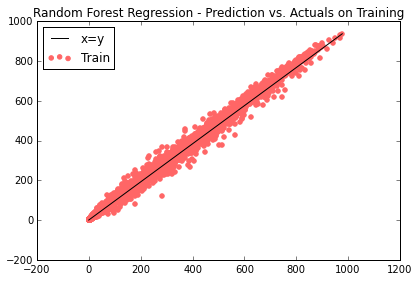

In [164]:
train_pred = np.zeros(len(train_df))
train_pred = inv_log(rf_cas.predict(train_cas)) + inv_log(rf_reg.predict(train_reg))

plt.figure()
train_actuals = train_df['count']

plt.scatter(train_actuals, train_pred, color = [1,.4,.4], label = 'Train')
plt.plot([0,np.max(train_actuals)],[0,np.max(train_pred)], color = [0,0,0], label = 'x=y')
plt.legend(loc ='best')
plt.title('Random Forest Regression - Prediction vs. Actuals on Training')

plt.tight_layout()
plt.savefig("../images/random_forest_regression.jpg", dpi=150)
plt.show()

In [168]:
output = inv_log(rf_reg.predict(kg_test_df[feature_names].values)) + inv_log(rf_cas.predict(kg_test_df[feature_names].values))
print output
print output.shape

[   9.74381944    4.2813101     3.10645494 ...,  149.17250454  109.90983335
   51.21838356]
(6493,)


In [169]:
make_kaggle_submission(output, 'random_forest_regression.csv')

--------------------------------------------------------------------------------
Generating file for Kaggle Submission File: random_forest_regression.csv
Shape of Kaggle Test Data:  (6493, 16)
Shape of Kaggle Test Predictions:  (6493,)
[  10.    4.    3. ...,  149.  110.   51.]
Shape of Final Predictions:  (6493,)
kaggle submission file generated


##Prepare Rolling Data Set

In [8]:
train_df = df.copy(deep=True)
train_df = processDateTime(train_df)
train_df = calcMedianByDay(train_df)
train_df = normalize_data(train_df)
train_df = add_weather_variables(train_df)

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [9]:
feature_names = [
    'season', 'holiday', 'workingday', \
    'weather', 'temp', 'humidity', 'windspeed', \
    'year', 'month', 'day', 'hours', 'dayofweek', \
    'mediancountbyday', \
    'spring', 'summer', 'fall', 'winter', \
    'clear', 'mist', 'lit_precip', 'hvy_precip', \
    'jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec', \
    'peak_hour', \
    'temp_bfr_1hr', 'temp_bfr_2hr', 'temp_bfr_3hr', 'temp_bfr_6hr', \
    'humidity_bfr_1hr', 'humidity_bfr_2hr', 'humidity_bfr_3hr', 'humidity_bfr_6hr', \
    'wind_bfr_1hr', 'wind_bfr_2hr', 'wind_bfr_3hr', 'wind_bfr_6hr', \
    'avg_temp_bfr_2hr', 'avg_temp_bfr_6hr', 'avg_temp_bfr_1day', \
    'avg_humidity_bfr_2hr', 'avg_humidity_bfr_6hr', 'avg_humidity_bfr_1day', \
    'avg_wind_bfr_2hr', 'avg_wind_bfr_6hr', 'avg_wind_bfr_1day']

In [63]:
def prepare_rolling_data(df, data_set = "train"):
    X = []
    Y_cas = []
    Y_reg = []

    df.datetime = pd.to_datetime(df.datetime)
    
    if ( data_set == "train"):
        global train_X
        global train_Y_cas
        global train_Y_reg

        for mon in np.arange(24):
            if mon < 12:
                date = "20/{:d}/11".format(mon+1) 
            else:
                date = "20/{:d}/12".format(mon+1-12)

            X.append(df.loc[(df['datetime'] < datetime.strptime(date, "%d/%m/%y")), feature_names])    
            Y_cas.append(df.loc[(df['datetime'] < datetime.strptime(date, "%d/%m/%y")), 'casual'])
            Y_reg.append(df.loc[(df['datetime'] < datetime.strptime(date, "%d/%m/%y")), 'registered'])
        
        train_X = X
        train_Y_cas = Y_cas
        train_Y_reg = Y_reg
    else:
        global test_X

        for mon in np.arange(24):
            if mon < 12:
                year = 2011
                month = mon+1
            else:
                year = 2012
                month = mon-11

            X.append(df.loc[(df['year'] == year) & (df['month'] == month ), feature_names])   
        
        #X.append(df.loc[(df['datetime'] = datetime.strptime("01/13", "%m/%y")), feature_names])
        #del X[0]

        test_X = X

In [11]:
prepare_rolling_data(train_df, "train")

In [12]:
print len(train_X)

24


In [13]:
for i in np.arange(24):
    print i, train_X[i].shape

0 (431, 55)
1 (877, 55)
2 (1323, 55)
3 (1778, 55)
4 (2234, 55)
5 (2690, 55)
6 (3146, 55)
7 (3602, 55)
8 (4055, 55)
9 (4510, 55)
10 (4966, 55)
11 (5422, 55)
12 (5875, 55)
13 (6330, 55)
14 (6785, 55)
15 (7239, 55)
16 (7695, 55)
17 (8151, 55)
18 (8607, 55)
19 (9063, 55)
20 (9519, 55)
21 (9975, 55)
22 (10430, 55)
23 (10886, 55)


In [14]:
kg_test_df = pd.read_csv("../data/test.csv")
kg_test_df = processDateTime(kg_test_df)
kg_test_df = calcMedianByDay(kg_test_df)
kg_test_df = normalize_data(kg_test_df)
kg_test_df = add_weather_variables(kg_test_df)

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [64]:
prepare_rolling_data(kg_test_df, "test")

In [65]:
print len(test_X)

for i in np.arange(24):
    print i, test_X[i].shape

24
0 (257, 55)
1 (203, 55)
2 (284, 55)
3 (264, 55)
4 (288, 55)
5 (264, 55)
6 (288, 55)
7 (275, 55)
8 (264, 55)
9 (288, 55)
10 (263, 55)
11 (285, 55)
12 (288, 55)
13 (237, 55)
14 (288, 55)
15 (264, 55)
16 (288, 55)
17 (264, 55)
18 (288, 55)
19 (288, 55)
20 (264, 55)
21 (252, 55)
22 (263, 55)
23 (286, 55)


In [17]:
print kg_test_df.shape
print train_df.shape

(6493, 108)
(10886, 111)


## Model on Rolling Data Set

In [19]:
rf_cas = []
rf_reg = []

for m in np.arange(24):
    print m
    rf_cas.append(ensmbl.RandomForestRegressor(n_estimators = 100, oob_score=True)) 
    rf_cas[m].fit(train_X[m], np.log(train_Y_cas[m] + 1))

    rf_reg.append(ensmbl.RandomForestRegressor(n_estimators = 100, oob_score=True)) 
    rf_reg[m].fit(train_X[m], np.log(train_Y_reg[m] + 1))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23


In [66]:
pred_rf_cas = []
pred_rf_reg = []

for m in np.arange(24):
    pred_rf_cas.append(rf_cas[m].predict(test_X[m]))
    pred_rf_reg.append(rf_reg[m].predict(test_X[m]))

In [67]:
print len(pred_rf_cas)
print len(pred_rf_reg)

24
24


In [68]:
for i in np.arange(24):
    print i, pred_rf_cas[i].shape, pred_rf_reg[i].shape

0 (257,) (257,)
1 (203,) (203,)
2 (284,) (284,)
3 (264,) (264,)
4 (288,) (288,)
5 (264,) (264,)
6 (288,) (288,)
7 (275,) (275,)
8 (264,) (264,)
9 (288,) (288,)
10 (263,) (263,)
11 (285,) (285,)
12 (288,) (288,)
13 (237,) (237,)
14 (288,) (288,)
15 (264,) (264,)
16 (288,) (288,)
17 (264,) (264,)
18 (288,) (288,)
19 (288,) (288,)
20 (264,) (264,)
21 (252,) (252,)
22 (263,) (263,)
23 (286,) (286,)


In [72]:
def chain_rows(df):
    chain = []
    for x in df:
        for y in x:
            chain.append(y)

    return chain

In [75]:
pred_cas = chain_rows(pred_rf_cas)
pred_reg = chain_rows(pred_rf_reg)

predictions = np.exp(pred_cas) + np.exp(pred_reg) 
predictions.shape, sum(predictions<0)

output = inv_log(pred_cas) + inv_log(pred_reg)
print output
print output.shape, sum(output<0)

[  10.54766477    4.96010287    3.89562041 ...,  161.07057723  119.68139329
   51.36026351]
(6493,) 0


In [70]:
make_kaggle_submission(output, 'rolling_random_forest_regression.csv')

80458
